In [1]:
import cv2
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
import time 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Conv2DTranspose # = Deconvolution2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from imagePreprocess import getImagesVarAndMean

data/resized/000034.jpg


In [10]:
# TODO:
# find how to use multithreading in jupyter on windows
# unet
# standardize images

In [2]:
def showHsv(img):    
    img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
    plt.imshow(img)
    plt.show()

In [3]:
img_in = cv2.imread('pic.jpg')
# maybe should switch to LAB colorspace?
hsv = cv2.cvtColor(img_in, cv2.COLOR_BGR2HSV)
print(hsv.shape)

h,s,v = cv2.split(hsv)
#print('s',s.shape)
s = (np.random.random(s.shape) * 255).astype('uint8')
h = (np.random.random(s.shape) * 255).astype('uint8')
#s = np.maximum(0, v)
#print(s)
hsv = cv2.merge([h,s,v])
# print('image with its value untouched, but saturation and hue randomized:');showHsv(hsv)

(1008, 1600, 3)


In [4]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))


In [9]:
def loadImgHsv(path):
    img_in = cv2.imread(path)
    hsv = cv2.cvtColor(img_in, cv2.COLOR_BGR2HSV)
    h,s,v = cv2.split(hsv)
    X = v
    Y = np.dstack((h,s))
    #print("loadX.shape", X.shape, 'loadY.shape', Y.shape)
    return X, Y

# celebA dataset from https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg
# 202,599 images of size 178x218

# data generator for feeding into memory parts of dataset
class DataGenerator(tf.keras.utils.Sequence):
    'data generator for feeding into memory parts of dataset'
    def __init__(self, list_IDs, batch_size=32, dim=(178,218), in_channels=1,
                 out_channels=2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, Y = self.__data_generation(list_IDs_temp)

        return X, Y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim))
        # target 2 channels
        Y = np.empty((self.batch_size, *self.dim, self.out_channels))
        # print(X.shape, Y.shape)
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i], Y[i] = loadImgHsv('data/img_celeba/' + ID)
#         print('X[i].shape:',X[0].shape)
#         print('X.shape:',X.shape,'Y.shape',Y.shape)
        X = np.expand_dims(X, axis=len(X.shape))
#         print('X[i].shape:',X[0].shape)
#         print('X.shape:',X.shape,'Y.shape',Y.shape)
        return X, Y

In [10]:
params = {'dim': (218, 178),
          'batch_size': 32,
          'in_channels': 1,
          'out_channels': 2,
          'shuffle': True}

data_IDs = os.listdir('data/img_celeba/')
print('dataset size',len(data_IDs))
splitAt = int(len(data_IDs)*0.01)
print('splitat', splitAt)
train_IDs = data_IDs[:splitAt]
print('train len', len(train_IDs))
val_IDs = data_IDs[splitAt:int(splitAt + splitAt/10)]
print('val len', len(val_IDs))

training_generator = DataGenerator(train_IDs, **params)
validation_generator = DataGenerator(val_IDs, **params)
print(training_generator[0][1].shape )

dataset size 202599
splitat 2025
train len 2025
val len 202
(32, 218, 178, 2)


In [116]:
# tmp = []
# print(len(training_generator))
# for i in range(len(training_generator)):
#     tmp.append(training_generator[i])
# print(len(tmp))
# tmp[0]
from tensorflow.keras.layers import UpSampling2D

In [154]:
def createModel(input_shape = (218,178)):
    input_shape = input_shape + (1,)
    model = Sequential()
    model.add(Conv2D(filters=16, kernel_size=(3, 3), strides=(3, 3), 
           activation='relu', input_shape=input_shape, padding='same'))
    #model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
    model.add(Conv2D(filters=16, kernel_size=(3, 3), strides=(3,3), activation=None))
    model.add(Conv2D(filters=16, kernel_size=(2, 2), strides=(1, 1), activation='relu'))
    
    print('m',model.output_shape)
    kernel_size = np.array(input_shape - np.array(model.output_shape[1:]) + 1)
    kernel_size = (kernel_size/10).astype(int)
    kernel_size = tuple(kernel_size[:-1])
    print('k',kernel_size)
    model.add(Conv2DTranspose(filters=6, kernel_size=kernel_size))
    kernel_size = (40,30)
    model.add(Conv2DTranspose(filters=3, kernel_size=kernel_size))
    kernel_size = (80,60)
    model.add(Conv2DTranspose(filters=3, kernel_size=kernel_size))
    kernel_size = (30,26)
    model.add(Conv2DTranspose(filters=2, kernel_size=kernel_size))
    kernel_size = (31,32)
    model.add(Conv2DTranspose(filters=2, kernel_size=kernel_size))
    model.add(Conv2D(filters=2, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='same'))

    model.compile(loss='mean_squared_error',
                  optimizer='adam',
                  metrics=['mae','accuracy'])
    return model
model = createModel()
model.summary()
print(model.output_shape)

m (None, 23, 19, 16)
k (19, 16)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_134 (Conv2D)          (None, 73, 60, 16)        160       
_________________________________________________________________
conv2d_135 (Conv2D)          (None, 24, 20, 16)        2320      
_________________________________________________________________
conv2d_136 (Conv2D)          (None, 23, 19, 16)        1040      
_________________________________________________________________
conv2d_transpose_149 (Conv2D (None, 41, 34, 6)         29190     
_________________________________________________________________
conv2d_transpose_150 (Conv2D (None, 80, 63, 3)         21603     
_________________________________________________________________
conv2d_transpose_151 (Conv2D (None, 159, 122, 3)       43203     
_________________________________________________________________
conv2d_transpose_152 (Conv2D (None, 188, 147

In [113]:
x = model.layers[0]
x.input

<tf.Tensor 'conv2d_89_input:0' shape=(?, 218, 178, 1) dtype=float32>

In [155]:
currTime = time.strftime("%d-%m-%Y-%H-%M-%S", time.localtime())
layers = ['convmax_convmax_4xDeConv']
NAME = f"test-tensorboard-{ currTime }-layers-" + "_".join(str(l) for l in layers)
print(NAME)

model = createModel()
tensorboard = TensorBoard(log_dir=f'logs/{NAME}')
model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    epochs=3,
                    use_multiprocessing=False,
                    workers=0,
                    callbacks=[tensorboard])
#mode.fit(X, y, batch_size=32, epochs=10, validation_split=0.2, callbacks=[tensorboard])

test-tensorboard-21-03-2019-23-22-39-layers-convmax_convmax_4xDeConv
m (None, 23, 19, 16)
k (19, 16)
Epoch 1/3
63/63 [==============================] - 17s 267ms/step - loss: 7748.2406 - mean_absolute_error: 62.1035 - acc: 0.5710 - val_loss: 7948.4205 - val_mean_absolute_error: 63.2585 - val_acc: 0.5830
Epoch 2/3
63/63 [==============================] - 9s 147ms/step - loss: 6100.9481 - mean_absolute_error: 54.4500 - acc: 0.6645 - val_loss: 5067.1694 - val_mean_absolute_error: 50.5047 - val_acc: 0.6875
Epoch 3/3
63/63 [==============================] - 9s 148ms/step - loss: 4642.3798 - mean_absolute_error: 49.1539 - acc: 0.6919 - val_loss: 4736.5539 - val_mean_absolute_error: 53.4452 - val_acc: 0.6944


In [156]:
model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    epochs=10,
                    use_multiprocessing=False,
                    workers=0,
                    callbacks=[tensorboard])

Epoch 1/10
63/63 [==============================] - 9s 149ms/step - loss: 4164.6001 - mean_absolute_error: 47.8377 - acc: 0.6923 - val_loss: 4294.3398 - val_mean_absolute_error: 49.8490 - val_acc: 0.6946
Epoch 2/10
63/63 [==============================] - 9s 148ms/step - loss: 4011.7390 - mean_absolute_error: 47.4006 - acc: 0.6918 - val_loss: 4040.1259 - val_mean_absolute_error: 47.8785 - val_acc: 0.6946
Epoch 3/10
63/63 [==============================] - 9s 148ms/step - loss: 3921.8965 - mean_absolute_error: 47.1015 - acc: 0.6917 - val_loss: 4069.5862 - val_mean_absolute_error: 49.4497 - val_acc: 0.6945
Epoch 4/10
63/63 [==============================] - 9s 148ms/step - loss: 3872.5759 - mean_absolute_error: 46.9734 - acc: 0.6917 - val_loss: 4207.8852 - val_mean_absolute_error: 51.2988 - val_acc: 0.6945
Epoch 5/10
63/63 [==============================] - 9s 148ms/step - loss: 3846.4210 - mean_absolute_error: 46.8915 - acc: 0.6918 - val_loss: 4236.7994 - val_mean_absolute_error: 51.705

In [83]:
def showImgFromPredict(hs, v, showDetails=False):
    '''hs- a list containing hue and saturation matrices
    v - value matrix.
    all three should be uint8
    '''
    hs, v = hs[0], v[0,...,0]
#     print('hs:',hs.shape)
    h, s = hs[...,0], hs[...,1]
    print('h',h.shape,'s',s.shape,'v',v.shape)
    print(h.dtype, s.dtype, v.dtype)
    hsv = cv2.merge([h,s,v])
    showHsv(hsv)    
    if not showDetails:
        return
    for i in range(2,-1,-1):
        pic = hsv[:,:,i]
        plt.imshow(pic, cmap='gray')
        plt.show()


In [103]:
def predictFromImage(img, showDetails=False):
    X, Y = validation_generator[1]
    print(X.shape, Y.shape)

    inX, inY = loadImgHsv(img )
    #print(inX.shape,inY.shape)
    inX, inY = inX[None,...,None], inY[None,:]
    #print(inX.shape,inY.shape)
    X, Y = X[10][None,:], Y[0][None,:]
    #print(X.shape, Y.shape)

    X, Y = inX, inY

    predY = model.predict(X)

    #print(X.dtype, X.min(), X.max(), X.mean())
    #predY = int(predY)
    #print(predY.min(), predY.max(), predY.mean() )
    predY = predY
    predY = np.maximum(predY, 0)
    X = X.astype('uint8')
    predY = predY.astype('uint8')
    #print(predY.min(), predY.max(), predY.mean() )

    showImgFromPredict(predY, X, showDetails)

(32, 218, 178, 1) (32, 218, 178, 2)
h (218, 178) s (218, 178) v (218, 178)
uint8 uint8 uint8


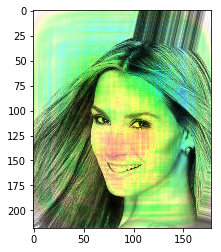

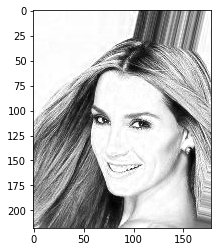

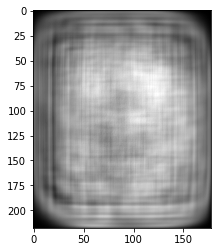

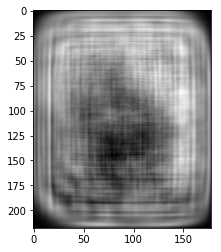

(32, 218, 178, 1) (32, 218, 178, 2)
h (218, 178) s (218, 178) v (218, 178)
uint8 uint8 uint8


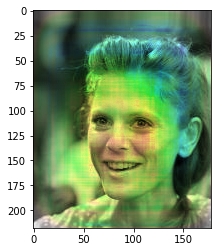

(32, 218, 178, 1) (32, 218, 178, 2)
h (218, 178) s (218, 178) v (218, 178)
uint8 uint8 uint8


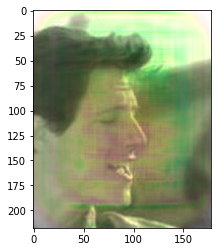

(32, 218, 178, 1) (32, 218, 178, 2)
h (218, 178) s (218, 178) v (218, 178)
uint8 uint8 uint8


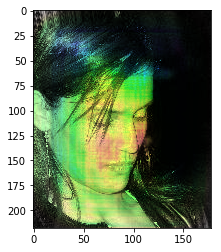

(32, 218, 178, 1) (32, 218, 178, 2)
h (218, 178) s (218, 178) v (218, 178)
uint8 uint8 uint8


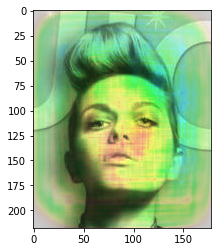

(32, 218, 178, 1) (32, 218, 178, 2)
h (218, 178) s (218, 178) v (218, 178)
uint8 uint8 uint8


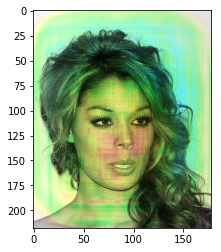

(32, 218, 178, 1) (32, 218, 178, 2)
h (218, 178) s (218, 178) v (218, 178)
uint8 uint8 uint8


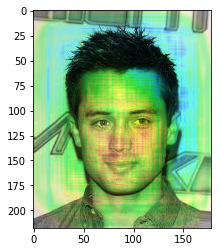

(32, 218, 178, 1) (32, 218, 178, 2)
h (218, 178) s (218, 178) v (218, 178)
uint8 uint8 uint8


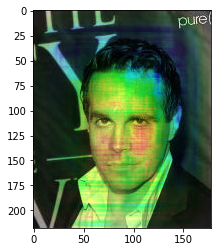

(32, 218, 178, 1) (32, 218, 178, 2)
h (218, 178) s (218, 178) v (218, 178)
uint8 uint8 uint8


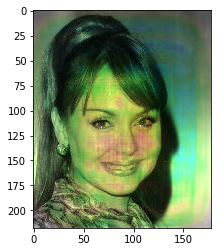

In [157]:
for i in range(1,10):
    predictFromImage(f'data/img_celeba/00000{i}.jpg', i==1)
